In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
## Zmienne ciągłe
from sklearn.preprocessing import( 
                    StandardScaler, 
                    MinMaxScaler,
                    Normalizer
)
## Zmienne kategoryczne
from sklearn.preprocessing import( 
                    OrdinalEncoder, 
                    OneHotEncoder
)
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Przygotowanie danych do nauki
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import (
                LeaveOneOut,
                cross_val_score
)
# Modele
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#Ulepszanie modelu
from sklearn.model_selection import( 
                GridSearchCV,
                learning_curve
                                   
)
from sklearn.metrics import (
                accuracy_score,
                roc_auc_score,
                recall_score,
                confusion_matrix,
                plot_roc_curve,
                roc_curve
)
 
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
    
#Zapisywanie modeli
import pickle

#Animacja progressbar
from tqdm.notebook import tqdm_notebook

# Ładowanie Danych

In [2]:
df_raw = pd.read_csv('./data_set/preprocessing/hd_dataSet.csv')
df_raw.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,male,typical angina,145.0,233.0,greater than 120mg/ml,left ventricular hypertrophy,150.0,no,2.3,downsloping,0.0,fixed defect,0
1,67.0,male,asymptomatic,160.0,286.0,lower than 120mg/ml,left ventricular hypertrophy,108.0,yes,1.5,flat,3.0,normal,1
2,67.0,male,asymptomatic,120.0,229.0,lower than 120mg/ml,left ventricular hypertrophy,129.0,yes,2.6,flat,2.0,reversable defect,1
3,37.0,male,non-anginal pain,130.0,250.0,lower than 120mg/ml,normal,187.0,no,3.5,downsloping,0.0,normal,0
4,41.0,female,atypical angina,130.0,204.0,lower than 120mg/ml,left ventricular hypertrophy,172.0,no,1.4,upsloping,0.0,normal,0


In [3]:
df = df_raw.copy()

# Podział danyhc na zestaw testowy i treningowy

Macierz cech: (297, 13)
Wektor atrybutu docelowego: (297,)
X_train:(237, 13)
X_test:(60, 13)
y_train:(237,)
y_test:(60,)


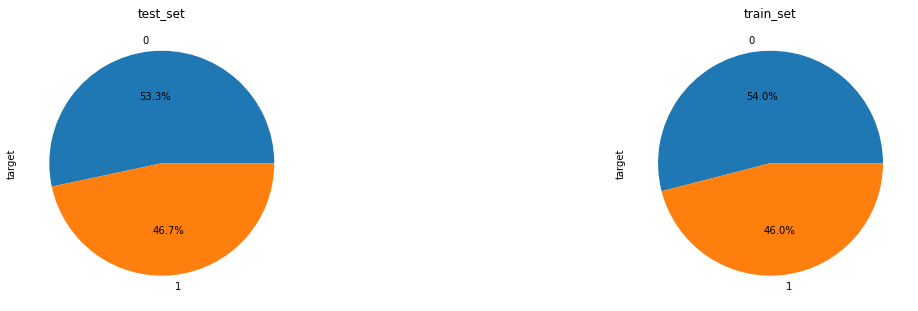

In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
print(f'Macierz cech: {X.shape}\nWektor atrybutu docelowego: {y.shape}')

data = train_test_split(X, y, test_size=0.2, random_state = 0, stratify=y)
X_train = data[0]
X_test = data[1]
y_train = data[2]
y_test = data[3]

print(f'X_train:{X_train.shape}')
print(f'X_test:{X_test.shape}')
print(f'y_train:{y_train.shape}')
print(f'y_test:{y_test.shape}')

print_target = [(y_test,'test_set'),(y_train,'train_set')]
plt.figure(figsize=(20,30))
for i,data in enumerate(print_target):
    plt.subplot(5,2,i+1)
    data[0].value_counts().plot(kind='pie', autopct="%.1f%%", title = data[1])

# Model Bazowy

In [5]:
base_model = DummyClassifier()
base_model.fit(X_train,y_train)
print(f'{base_model.score(X_test,y_test)}')

#Macierz pomylek
y_pred_lr = base_model.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, y_pred_lr)
print("confusion matrix")
print(lr_conf_matrix)

0.5333333333333333
confusion matrix
[[32  0]
 [28  0]]


# Badanie algorytmów

## Przygotowanie listy algorytmów do badania wraz z parametrami regularyzacji

In [6]:
# klasyfikatory                            
classifiers = [
    (LogisticRegression(solver = 'liblinear'), # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
     {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
      'classifier__penalty': ['l1', 'l2'] }
    ),
    (KNeighborsClassifier(),
     {'classifier__n_neighbors': [i for i in range(1,11)], 
      'classifier__metric' : ['minkowski', 'euclidean', 'manhattan']}
    ),
    (RandomForestClassifier(),
     {'classifier__criterion': ['gini', 'entropy'], 
      'classifier__max_depth' : [None,2,3,4,5,6,7,8,9,10]}
    ),
    (SVC(),
     [{'classifier__kernel': ['rbf'], 
      'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], 
      'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100]
     }, 
     {'classifier__kernel': ['linear'], 
      'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
     }
     ]
    ), 
    (DecisionTreeClassifier(),
     {'classifier__criterion': ['gini', 'entropy'], 
      'classifier__max_depth' : [None,2,3,4,5,6,7,8,9,10],
      'classifier__max_leaf_nodes': [None,2,3,4,5,6,7,8,9,10],
      'classifier__min_samples_leaf': [1,2,3,4,5]}
    )
]

# transformatory dla kolumn liczbowych
scalers = [StandardScaler(), MinMaxScaler(), Normalizer(), None]
 
# transformatory dla kolumn kategorycznych
cat_transformers = [OrdinalEncoder(), OneHotEncoder(drop='first')]

## Przygotowanie transforamtorów oraz potoków 

In [7]:
#Potok odpowiadający za transformacje warotści numerycznych
transformer_numerical = Pipeline(steps = [
                                ('num_trans', None)
                                ])

#Potok odpowiadający za transformacje wartości kategorycznych 
transformer_categorical = Pipeline(steps = [
                                  ('cat_trans', None)
                                  ])

#Transformator odowiadający za zmiane kolumn
preprocessor = ColumnTransformer(
    transformers=[
        ('col_numerical', transformer_numerical, selector(dtype_exclude="object")),
        ('col_categorical', transformer_categorical, selector(dtype_include="object"))])

# Testowanie działania metod 
print(f'Numerczyne kolumny: {selector(dtype_exclude="object")(X_test)}\n')
print(f'Dyskretne kolumny: {selector(dtype_include="object")(X_test)}')

print('\n\t\t\t=== SPRAWDZANIE POPRAWNEJ TRANSFORMACJI ===')
transformer_params = {
    'col_numerical__num_trans': StandardScaler(),
    'col_categorical__cat_trans': OneHotEncoder(drop='first')
    }
test_preprocessor = preprocessor
test_preprocessor.set_params(**transformer_params)

models_df = pd.DataFrame()
models_df = models_df.append(pd.DataFrame(test_preprocessor.fit_transform(X_train)))
models_df.head()

Numerczyne kolumny: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

Dyskretne kolumny: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

			=== SPRAWDZANIE POPRAWNEJ TRANSFORMACJI ===


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.629846,1.113910,-0.164650,0.948051,-0.137847,-0.725697,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,-1.033677,-1.130357,-1.692675,-0.487795,-0.926126,-0.725697,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.146465,0.523313,-0.871361,0.251883,1.789057,-0.725697,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.479169,-1.248476,0.102755,0.425925,-0.926126,-0.725697,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.518944,0.228015,-0.279251,0.512946,-0.488193,-0.725697,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## Trenowanie modelu

In [8]:
#Tabela na wyniki
models_df = pd.DataFrame()

loo = LeaveOneOut() 

best_models = {}
#pomocniczy potok
pipe = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('classifier', None)
            ])

touple_with_transform = [(num_t, cat_t) for num_t in scalers for cat_t in cat_transformers]

for model,param_grid in tqdm_notebook(classifiers,desc='Algorithm Study'):
    for num_tr,cat_tr in tqdm_notebook(touple_with_transform, 
                                       desc=f'Transformations Study for {model.__class__.__name__}'):
        pip_params = {
            'preprocessor__col_numerical__num_trans': num_tr,
            'preprocessor__col_categorical__cat_trans': cat_tr,
            'classifier': model}
        
        pipe.set_params(**pip_params)
        try:
            #Trening modelu
            grid_search = GridSearchCV(pipe, param_grid, cv=10,n_jobs = -1,  scoring='accuracy' )
            grid_search.fit(X_train, y_train)
            
            #Pozyskanie potrzebnych danych
            train_score_cv = grid_search.best_score_
            std_train_score_cv = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
            y_predict = grid_search.predict(X_test)
            test_score = accuracy_score(y_test, y_predict)#grid_search.score(X_test, y_test)
            recall = recall_score(y_test, y_predict, average=None)
            auc = roc_auc_score(y_test, y_predict)
            
            #Zapisywanie każdego obiektu
            param_dict = {
                        'model': model.__class__.__name__,
                        'num_trans': num_tr.__class__.__name__,
                        'cat_trans': cat_tr.__class__.__name__,
                        'train_score': train_score_cv,
                        'std_train_score': std_train_score_cv,
                        'test_score': test_score,
                        'recall_test_1':recall[1],
                        'recall_test_0':recall[0],
                        'AUC': auc
            }
            #Zapisywanie "najlepszego" modelu do tablicy
            if model.__class__.__name__ in best_models:
                if best_models[model.__class__.__name__][1] <= test_score:
                    if best_models[model.__class__.__name__][2] < auc:
                        best_models[model.__class__.__name__]= (grid_search.best_estimator_, test_score, auc , recall[1])                       
            else:
                best_models[model.__class__.__name__]= (grid_search.best_estimator_, test_score, auc, recall[1])
                
            # Dodanie 
            models_df = models_df.append(pd.DataFrame(param_dict, index=[0]))
        except:
            print(f'W trakcie trenowania {model.__class__.__name__} nastąpił błąd')
            
models_df.reset_index(drop=True, inplace=True)

Algorithm Study:   0%|          | 0/5 [00:00<?, ?it/s]

Transformations Study for LogisticRegression:   0%|          | 0/8 [00:00<?, ?it/s]

Transformations Study for KNeighborsClassifier:   0%|          | 0/8 [00:00<?, ?it/s]

Transformations Study for RandomForestClassifier:   0%|          | 0/8 [00:00<?, ?it/s]

Transformations Study for SVC:   0%|          | 0/8 [00:00<?, ?it/s]

Transformations Study for DecisionTreeClassifier:   0%|          | 0/8 [00:00<?, ?it/s]

## Wyniki algorytmów cz.1

In [9]:
results = pd.DataFrame(grid_search.cv_results_) 
# pokaż wszystkie kolumny 
#pd.set_option('display.max_columns', None) 
results[['mean_test_score','param_classifier__criterion','param_classifier__max_depth','param_classifier__max_leaf_nodes','param_classifier__min_samples_leaf']].sort_values('mean_test_score', ascending=False).head(10)

,mean_test_score,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_leaf_nodes,param_classifier__min_samples_leaf
324,0.759058,gini,7,5,5
273,0.759058,gini,6,5,4
473,0.759058,gini,10,5,4
374,0.759058,gini,8,5,5
323,0.759058,gini,7,5,4
373,0.759058,gini,8,5,4
24,0.759058,gini,None,5,5
23,0.759058,gini,None,5,4
173,0.759058,gini,4,5,4
128,0.759058,gini,3,6,4


In [10]:
models_df[models_df['model']== 'DecisionTreeClassifier'].sort_values('test_score', ascending=False)

,model,num_trans,cat_trans,train_score,std_train_score,test_score,recall_test_1,recall_test_0,AUC
32,DecisionTreeClassifier,StandardScaler,OrdinalEncoder,0.797101,0.063011,0.800000,0.785714,0.81250,0.799107
34,DecisionTreeClassifier,MinMaxScaler,OrdinalEncoder,0.797101,0.063011,0.800000,0.785714,0.81250,0.799107
36,DecisionTreeClassifier,Normalizer,OrdinalEncoder,0.817754,0.070323,0.800000,0.750000,0.84375,0.796875
37,DecisionTreeClassifier,Normalizer,OneHotEncoder,0.788768,0.065635,0.800000,0.821429,0.78125,0.801339
38,DecisionTreeClassifier,NoneType,OrdinalEncoder,0.797101,0.063011,0.800000,0.785714,0.81250,0.799107
33,DecisionTreeClassifier,StandardScaler,OneHotEncoder,0.759058,0.109843,0.716667,0.642857,0.78125,0.712054
35,DecisionTreeClassifier,MinMaxScaler,OneHotEncoder,0.759058,0.109843,0.716667,0.642857,0.78125,0.712054
39,DecisionTreeClassifier,NoneType,OneHotEncoder,0.759058,0.109843,0.716667,0.642857,0.78125,0.712054


In [11]:
models_df.sort_values('test_score', ascending=False)

,model,num_trans,cat_trans,train_score,std_train_score,test_score,recall_test_1,recall_test_0,AUC
6,LogisticRegression,NoneType,OrdinalEncoder,0.839674,0.055532,0.900000,0.821429,0.96875,0.895089
0,LogisticRegression,StandardScaler,OrdinalEncoder,0.839674,0.066878,0.883333,0.785714,0.96875,0.877232
26,SVC,MinMaxScaler,OrdinalEncoder,0.835145,0.066567,0.883333,0.821429,0.93750,0.879464
24,SVC,StandardScaler,OrdinalEncoder,0.847826,0.060465,0.883333,0.785714,0.96875,0.877232
18,RandomForestClassifier,MinMaxScaler,OrdinalEncoder,0.826630,0.074641,0.883333,0.785714,0.96875,0.877232
20,RandomForestClassifier,Normalizer,OrdinalEncoder,0.831341,0.069907,0.883333,0.821429,0.93750,0.879464
2,LogisticRegression,MinMaxScaler,OrdinalEncoder,0.852355,0.075477,0.883333,0.785714,0.96875,0.877232
4,LogisticRegression,Normalizer,OrdinalEncoder,0.835507,0.068424,0.883333,0.785714,0.96875,0.877232
22,RandomForestClassifier,NoneType,OrdinalEncoder,0.822826,0.066709,0.866667,0.750000,0.96875,0.859375
30,SVC,NoneType,OrdinalEncoder,0.839130,0.082262,0.866667,0.750000,0.96875,0.859375


In [12]:
models_df[['model', 'test_score', 'train_score']] \
    .groupby('model') \
    .aggregate({
        'test_score': ['mean','std', 'min', 'max'],
        'train_score': ['mean','std', 'min', 'max']
        }) \
    .reset_index() \
    .sort_values(('test_score', 'mean'), ascending=False)

model test_score                                \
                                mean       std       min       max   
2      LogisticRegression   0.870833  0.019416  0.850000  0.900000   
4                     SVC   0.850000  0.026726  0.816667  0.883333   
3  RandomForestClassifier   0.837500  0.039591  0.766667  0.883333   
0  DecisionTreeClassifier   0.768750  0.043129  0.716667  0.800000   
1    KNeighborsClassifier   0.768750  0.085188  0.633333  0.850000   

  train_score                                
         mean       std       min       max  
2    0.840421  0.012031  0.814674  0.852717  
4    0.825498  0.020958  0.793116  0.847826  
3    0.823279  0.004684  0.818659  0.831341  
0    0.784375  0.022495  0.759058  0.817754  
1    0.789515  0.042150  0.721377  0.826993

In [13]:
models_df[['model','num_trans', 'test_score', 'train_score']] \
    .groupby(['model','num_trans']) \
    .aggregate({
        'test_score': ['mean','std', 'min', 'max'],
        'train_score': ['mean','std', 'min', 'max']
        }) \
    .reset_index() \

model       num_trans test_score                      \
                                                 mean       std       min   
0   DecisionTreeClassifier    MinMaxScaler   0.758333  0.058926  0.716667   
1   DecisionTreeClassifier        NoneType   0.758333  0.058926  0.716667   
2   DecisionTreeClassifier      Normalizer   0.800000  0.000000  0.800000   
3   DecisionTreeClassifier  StandardScaler   0.758333  0.058926  0.716667   
4     KNeighborsClassifier    MinMaxScaler   0.808333  0.011785  0.800000   
5     KNeighborsClassifier        NoneType   0.633333  0.000000  0.633333   
6     KNeighborsClassifier      Normalizer   0.800000  0.000000  0.800000   
7     KNeighborsClassifier  StandardScaler   0.833333  0.023570  0.816667   
8       LogisticRegression    MinMaxScaler   0.875000  0.011785  0.866667   
9       LogisticRegression        NoneType   0.875000  0.035355  0.850000   
10      LogisticRegression      Normalizer   0.866667  0.023570  0.850000   
11      LogisticRegression  StandardScaler   0.866667  0.023570  0.850000   
12  RandomForestClassifier    MinMaxScaler   0.825000  0.082496  0.766667   
13  RandomForestClassifier        NoneType   0.841667  0.035355  0.816667   
14  RandomForestClassifier      Normalizer   0.850000  0.047140  0.816667   
15  RandomForestClassifier  StandardScaler   0.833333  0.000000  0.833333   
16                     SVC    MinMaxScaler   0.858333  0.035355  0.833333   
17                     SVC        NoneType   0.858333  0.011785  0.850000   
18                     SVC      Normalizer   0.833333  0.023570  0.816667   
19                     SVC  StandardScaler   0.850000  0.047140  0.816667   

             train_score                                
         max        mean       std       min       max  
0   0.800000    0.778080  0.026901  0.759058  0.797101  
1   0.800000    0.778080  0.026901  0.759058  0.797101  
2   0.800000    0.803261  0.020496  0.788768  0.817754  
3   0.800000    0.778080  0.026901  0.759058  0.797101  
4   0.816667    0.816576  0.014731  0.806159  0.826993  
5   0.633333    0.723370  0.002818  0.721377  0.725362  
6   0.800000    0.799547  0.008583  0.793478  0.805616  
7   0.850000    0.818569  0.005764  0.814493  0.822645  
8   0.883333    0.852536  0.000256  0.852355  0.852717  
9   0.900000    0.842029  0.003331  0.839674  0.844384  
10  0.883333    0.825091  0.014731  0.814674  0.835507  
11  0.883333    0.842029  0.003331  0.839674  0.844384  
12  0.883333    0.822736  0.005508  0.818841  0.826630  
13  0.866667    0.820743  0.002946  0.818659  0.822826  
14  0.883333    0.829167  0.003074  0.826993  0.831341  
15  0.833333    0.820471  0.002562  0.818659  0.822283  
16  0.883333    0.835507  0.000512  0.835145  0.835870  
17  0.866667    0.831250  0.011145  0.823370  0.839130  
18  0.850000    0.793297  0.000256  0.793116  0.793478  
19  0.883333    0.841938  0.008326  0.836051  0.847826

In [14]:
models_df[['model','cat_trans', 'test_score', 'train_score']] \
    .groupby(['model','cat_trans']) \
    .aggregate({
        'test_score': ['mean','std', 'min', 'max'],
        'train_score': ['mean','std', 'min', 'max']
        }) \
    .reset_index() \

model       cat_trans test_score                      \
                                                mean       std       min   
0  DecisionTreeClassifier   OneHotEncoder   0.737500  0.041667  0.716667   
1  DecisionTreeClassifier  OrdinalEncoder   0.800000  0.000000  0.800000   
2    KNeighborsClassifier   OneHotEncoder   0.762500  0.086469  0.633333   
3    KNeighborsClassifier  OrdinalEncoder   0.775000  0.096705  0.633333   
4      LogisticRegression   OneHotEncoder   0.854167  0.008333  0.850000   
5      LogisticRegression  OrdinalEncoder   0.887500  0.008333  0.883333   
6  RandomForestClassifier   OneHotEncoder   0.808333  0.028868  0.766667   
7  RandomForestClassifier  OrdinalEncoder   0.866667  0.023570  0.833333   
8                     SVC   OneHotEncoder   0.829167  0.015957  0.816667   
9                     SVC  OrdinalEncoder   0.870833  0.015957  0.850000   

            train_score                                
        max        mean       std       min       max  
0  0.800000    0.766486  0.014855  0.759058  0.788768  
1  0.800000    0.802264  0.010326  0.797101  0.817754  
2  0.816667    0.783877  0.042553  0.721377  0.814493  
3  0.850000    0.795154  0.047433  0.725362  0.826993  
4  0.866667    0.839040  0.016712  0.814674  0.852717  
5  0.900000    0.841803  0.007304  0.835507  0.852355  
6  0.833333    0.820788  0.004137  0.818659  0.826993  
7  0.883333    0.825770  0.004187  0.822283  0.831341  
8  0.850000    0.822192  0.020042  0.793478  0.836051  
9  0.883333    0.828804  0.024374  0.793116  0.847826

## Porównanie najlepszych algorytmów

In [15]:
#best_models to tablica zawierająca tuplety (estymator, acc)
for i in best_models.keys():
    print(f'{i} najlepsze acc wynosi: {best_models[i][1]:.2f} | {best_models[i][2]:.2f} | {best_models[i][3]:.2f}')

LogisticRegression najlepsze acc wynosi: 0.90 | 0.90 | 0.82
KNeighborsClassifier najlepsze acc wynosi: 0.85 | 0.84 | 0.75
RandomForestClassifier najlepsze acc wynosi: 0.88 | 0.88 | 0.82
SVC najlepsze acc wynosi: 0.88 | 0.88 | 0.82
DecisionTreeClassifier najlepsze acc wynosi: 0.80 | 0.80 | 0.82


### Macierz pomyłek

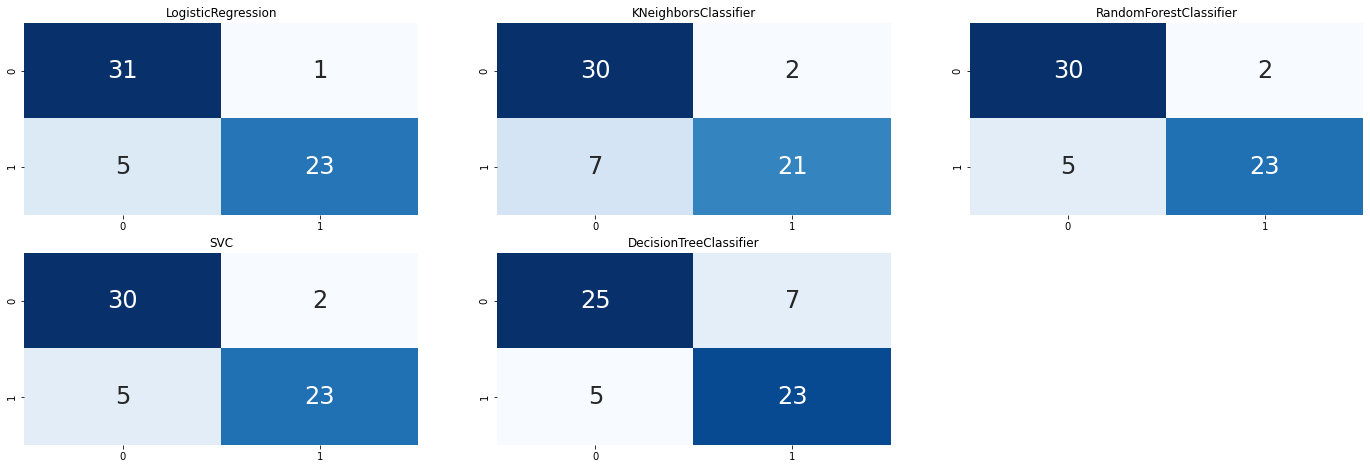

In [16]:
#Tworzenie tablicy zawierającej informacje o TP, FP, TN, FN
plt.figure(figsize=(24,12))
for i,name_model in enumerate(best_models.keys()):
    plt.subplot(3,3,i+1)
    y_pred_to_matrix = best_models[name_model][0].predict(X_test)
    lr_conf_matrix = confusion_matrix(y_test, y_pred_to_matrix)
    
    plt.title(f'{name_model}')
    sns.heatmap(lr_conf_matrix,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

### Wykres ROC

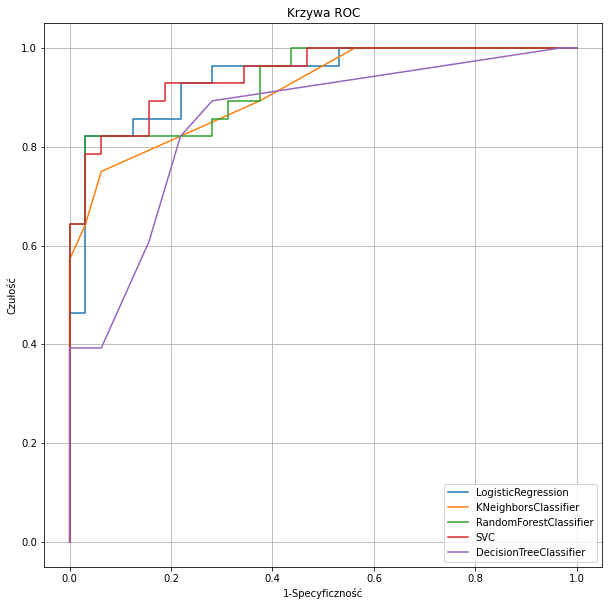

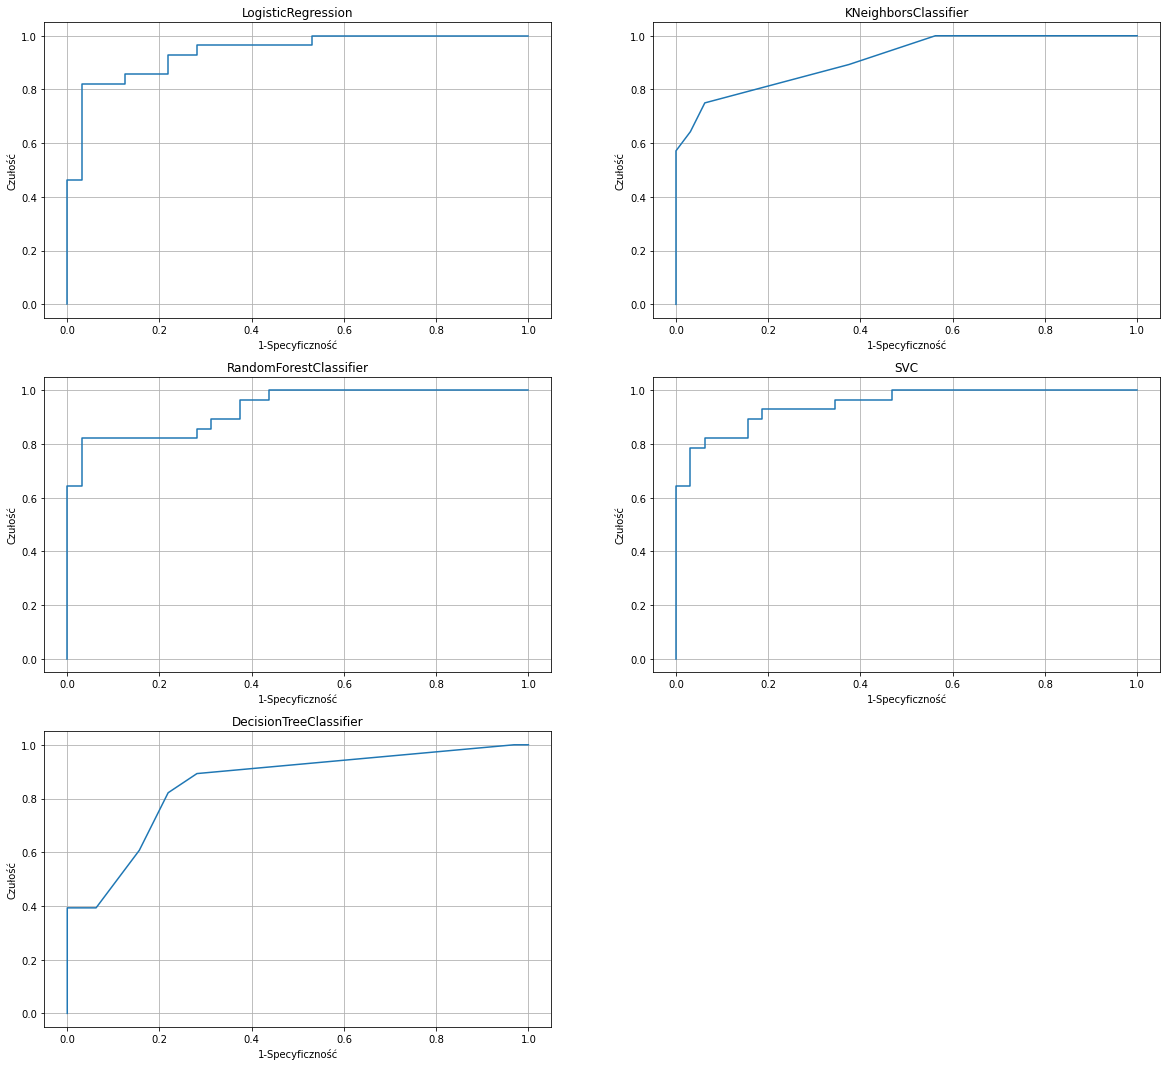

In [17]:
list_target_probabilities = {}# Słownik zawierjący ...
for name_model in best_models.keys():
    if name_model != 'SVC':
        list_target_probabilities[name_model] = best_models[name_model][0].predict_proba(X_test)[:,1]
    else:
        list_target_probabilities[name_model] = best_models[name_model][0].decision_function(X_test)
        
plt.figure(figsize=(10, 10))
for i in list_target_probabilities.keys():
    czulosci, specyficznosci, progi = roc_curve(y_test,list_target_probabilities[i])
    plt.plot(czulosci, specyficznosci) 
plt.legend(list_target_probabilities.keys())
plt.title("Krzywa ROC")
plt.xlabel("1-Specyficzność")
plt.ylabel("Czułość")
plt.grid() #Dodanie siatki
plt.show()# Wyrysowanie wykresu

plt.figure(figsize=(20,25))
for i,model_name in enumerate(list_target_probabilities.keys()):
    plt.subplot(4,2,i+1)
    czulosci, specyficznosci, progi = roc_curve(y_test,list_target_probabilities[model_name])
    plt.title(f"{model_name}")
    plt.xlabel("1-Specyficzność")
    plt.ylabel("Czułość")
    plt.grid() #Dodanie siatki
    plt.plot(czulosci, specyficznosci) 

### Krzywa nauki

### Cross - Validation na całym zbiorze

In [18]:
cv_scores = {}
for name_model in best_models.keys():
    cv_scores[name_model] = cross_val_score(best_models[name_model][0], X, y, cv=10)
    
for name_model in cv_scores.keys():
    print(f'{name_model} : {cv_scores[name_model].mean()}')

LogisticRegression : 0.8449425287356324
KNeighborsClassifier : 0.8110344827586207
RandomForestClassifier : 0.8449425287356321
SVC : 0.8482758620689657
DecisionTreeClassifier : 0.7779310344827587


In [19]:
for name_model in cv_scores.keys():
    print(f'{name_model} :\n {cv_scores[name_model]}')

LogisticRegression :
 [0.86666667 0.83333333 0.76666667 0.96666667 0.9        0.83333333
 0.8        0.93103448 0.72413793 0.82758621]
KNeighborsClassifier :
 [0.9        0.8        0.86666667 0.83333333 0.76666667 0.76666667
 0.86666667 0.82758621 0.68965517 0.79310345]
RandomForestClassifier :
 [0.9        0.86666667 0.86666667 0.96666667 0.86666667 0.73333333
 0.76666667 0.89655172 0.72413793 0.86206897]
SVC :
 [0.9        0.86666667 0.8        0.93333333 0.86666667 0.83333333
 0.8        0.86206897 0.75862069 0.86206897]
DecisionTreeClassifier :
 [0.83333333 0.66666667 0.8        0.86666667 0.83333333 0.7
 0.7        0.79310345 0.75862069 0.82758621]


<AxesSubplot:>

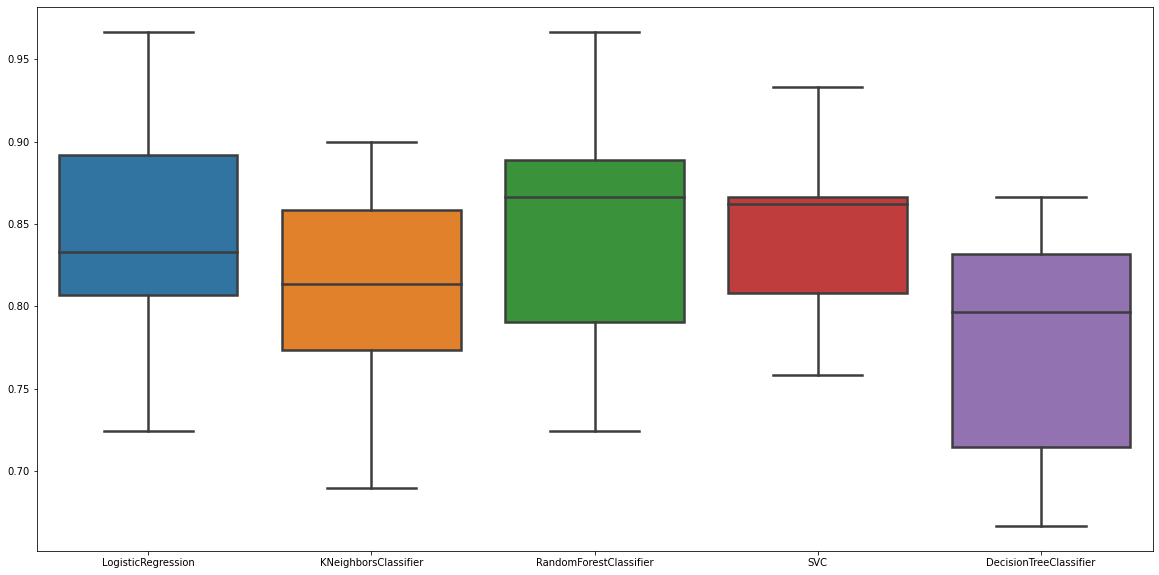

In [20]:
df_scores = pd.DataFrame(data=cv_scores)
plt.figure(figsize=(20,10))
sns.boxplot(data=df_scores, linewidth=2.5)

### Przetrenowanie algorytmów na całym zbiorze danych 

Przed dodaniem algorytmów na produkcje możemy przetrenować je za pomocą całego zbioru danych

In [21]:
for name_model in tqdm_notebook(best_models.keys(),desc='Algorithm Study'):
    best_models[name_model][0].fit(X,y)

Algorithm Study:   0%|          | 0/5 [00:00<?, ?it/s]

# Zapisanie najlepszych modeli z rozszerzeniem .bin

In [22]:
for name_model in best_models.keys():
    with open(f"./models/{name_model}.bin", 'wb') as f_out:
        pickle.dump(best_models[name_model][0], f_out) # write final_model in .bin file
        f_out.close()  # close the file 
    
with open('./models/SVC.bin', 'rb') as f_in:
    model = pickle.load(f_in)
    
model.score(X_test, y_test)


0.8833333333333333

# Testowanie, czy zapisany model działa 

In [23]:
patient = pd.DataFrame()
patient = patient.append(pd.DataFrame([[63.0,'male', 'typical angina',145.0,233.0,
                                        'greater than 120mg/ml', 'left ventricular hypertrophy', 
                                        150.0, 'no',2.3, 'downsloping', 0.0,'fixed defect']]))
patient.columns = ['age', 'sex', 'cp', 
               'trestbps', 'chol', 'fbs',
               'restecg', 'thalach', 'exang', 
               'oldpeak', 'slope', 'ca',
               'thal']
model.predict(patient)[0]

0